# PETL-AST: Conformer Adapter on ESC-50

**Paper**: Parameter-Efficient Transfer Learning of Audio Spectrogram Transformers (Cappellazzo et al., 2024)

**Runtime**: Go to **Runtime → Change runtime type → T4 GPU** before running.

---

## 1. Setup

In [ ]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4


In [ ]:
%cd /content
!rm -rf PETL-AST-Project

# Download repo as tarball (more reliable than git clone on Colab)
!wget -q https://github.com/yuvalanavi/PETL-AST-Project/archive/refs/heads/main.tar.gz -O repo.tar.gz
!tar -xzf repo.tar.gz && mv PETL-AST-Project-main PETL-AST-Project && rm repo.tar.gz

%cd PETL-AST-Project
!ls

/content
/content/PETL-AST-Project
dataset		  evaluation.py  PETL_AST_Colab.ipynb  src
docs		  hparams	 readme.txt	       train.py
download_data.sh  main.py	 requirements.txt      utils


In [ ]:
# Install dependencies (torch is already on Colab — only extra packages get installed)
# NOTE: pip may show red warnings about numpy conflicts with jax/opencv — these are harmless.
!pip install -r requirements.txt -q
!python -c "from transformers import ASTModel; print('transformers OK')"
!python -c "import librosa; print('librosa OK')"

transformers OK
librosa OK


## 1.5 Mount Google Drive (crash protection)

Checkpoints and training logs are saved to Google Drive via a symlink.
If the Colab runtime resets, your completed folds survive on Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

DRIVE_OUTPUT = '/content/drive/MyDrive/PETL-AST-outputs'
LOCAL_OUTPUT = '/content/PETL-AST-Project/outputs'

os.makedirs(DRIVE_OUTPUT, exist_ok=True)

# Symlink local outputs/ → Drive so all saves go to Drive automatically
if os.path.isdir(LOCAL_OUTPUT) and not os.path.islink(LOCAL_OUTPUT):
    # Move any existing local outputs to Drive first
    import shutil
    for item in os.listdir(LOCAL_OUTPUT):
        shutil.move(os.path.join(LOCAL_OUTPUT, item), os.path.join(DRIVE_OUTPUT, item))
    os.rmdir(LOCAL_OUTPUT)

if not os.path.exists(LOCAL_OUTPUT):
    os.symlink(DRIVE_OUTPUT, LOCAL_OUTPUT)

print(f"outputs/ → {os.path.realpath(LOCAL_OUTPUT)}")
print(f"Existing files on Drive: {os.listdir(DRIVE_OUTPUT)}")

## 2. Download ESC-50 Dataset

In [ ]:
%cd /content/PETL-AST-Project
!bash download_data.sh

/content/PETL-AST-Project
Download complete. Dataset at data/ESC-50/
  Audio files: 2000 files


In [ ]:
# Verify dataset structure
import os
audio_dir = 'data/ESC-50/audio'
meta_file = 'data/ESC-50/meta/esc50.csv'
n_files = len(os.listdir(audio_dir)) if os.path.isdir(audio_dir) else 0
print(f"Audio files: {n_files}")
print(f"Metadata exists: {os.path.isfile(meta_file)}")
assert n_files == 2000, f"Expected 2000 audio files, got {n_files}"
print("Dataset OK ✓")

Audio files: 2000
Metadata exists: True
Dataset OK ✓


## 3. Smoke Test (1 fold, 3 epochs)

In [ ]:
# Smoke test: temporarily override epochs in yaml, run 1 fold
import yaml
with open('hparams/train.yaml') as f:
    hp = yaml.safe_load(f)
original_epochs = hp['epochs_ESC']

hp['epochs_ESC'] = 3  # override for smoke test
with open('hparams/train.yaml', 'w') as f:
    yaml.dump(hp, f, default_flow_style=False)

!python train.py \
    --data_path 'data' \
    --dataset_name 'ESC-50' \
    --method 'adapter' \
    --adapter_block 'conformer' \
    --adapter_type 'Pfeiffer' \
    --seq_or_par 'parallel' \
    --reduction_rate_adapter 96 \
    --kernel_size 8 \
    --device cuda \
    --save_best_ckpt True --output_path '/outputs'

# Restore original epochs
hp['epochs_ESC'] = original_epochs
with open('hparams/train.yaml', 'w') as f:
    yaml.dump(hp, f, default_flow_style=False)
print(f"Restored epochs_ESC to {original_epochs}")

2026-02-20 12:41:12.334200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771591272.355482   18248 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771591272.362351   18248 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771591272.385056   18248 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771591272.385088   18248 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771591272.385097   18248 computation_placer.cc:177] computation placer alr

In [ ]:
# Verify smoke test outputs
import os, csv

# Check checkpoint exists
ckpt = 'outputs/bestmodel_fold0'
print(f"Checkpoint exists: {os.path.isfile(ckpt)}")

# Read and display CSV log
log_path = 'outputs/log_fold0.csv'
if os.path.isfile(log_path):
    with open(log_path) as f:
        rows = list(csv.DictReader(f))
    print(f"\nTraining log ({len(rows)} epochs):")
    print(f"{'Epoch':>5} {'Train Loss':>11} {'Train Acc':>10} {'Val Loss':>10} {'Val Acc':>10}")
    for r in rows:
        print(f"{r['epoch']:>5} {float(r['train_loss']):>11.4f} {float(r['train_acc'])*100:>9.2f}% {float(r['val_loss']):>10.4f} {float(r['val_acc'])*100:>9.2f}%")

    # Sanity checks
    losses = [float(r['train_loss']) for r in rows]
    if losses[-1] < losses[0]:
        print("\n✓ Loss is decreasing — training is working")
    else:
        print("\n✗ WARNING: Loss did not decrease")
else:
    print(f"ERROR: {log_path} not found")

Checkpoint exists: False
ERROR: outputs/log_fold0.csv not found


**Check**: Loss should decrease over 3 epochs. Trainable params should be ~271K.  
If this works, proceed to full training below.

## 4. Full Training (5 folds × 50 epochs)

**Estimated time**: ~4-5 hours on T4. Checkpoints and logs are saved to Google Drive (via the symlink from step 1.5), so they survive runtime resets.

**If Colab crashes**: Reconnect, re-run cells 1–1.5 (setup + Drive mount), then re-run the training cell below. Note: the current training script restarts all folds — completed fold checkpoints on Drive are preserved but will be overwritten on re-run.

In [32]:
# Clean smoke test outputs before full run
!rm -rf outputs/*

In [ ]:
!python train.py \
    --data_path 'data' \
    --dataset_name 'ESC-50' \
    --method 'adapter' \
    --adapter_block 'conformer' \
    --adapter_type 'Pfeiffer' \
    --seq_or_par 'parallel' \
    --reduction_rate_adapter 96 \
    --kernel_size 8 \
    --device cuda \
    --save_best_ckpt True --output_path '/outputs'
print("Training complete. Log saved to outputs/training.log")

2026-02-20 12:20:08.853740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771590008.874164   12782 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771590008.880971   12782 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771590008.899541   12782 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771590008.899566   12782 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771590008.899577   12782 computation_placer.cc:177] computation placer alr

## 5. Generate Convergence Plots

In [30]:
!python utils/visualization.py --log outputs/training.log --output_dir outputs/plots

Saved: outputs/plots/convergence_fold0.png
Saved: outputs/plots/convergence_all_folds.png


outputs/plots/convergence_all_folds.png


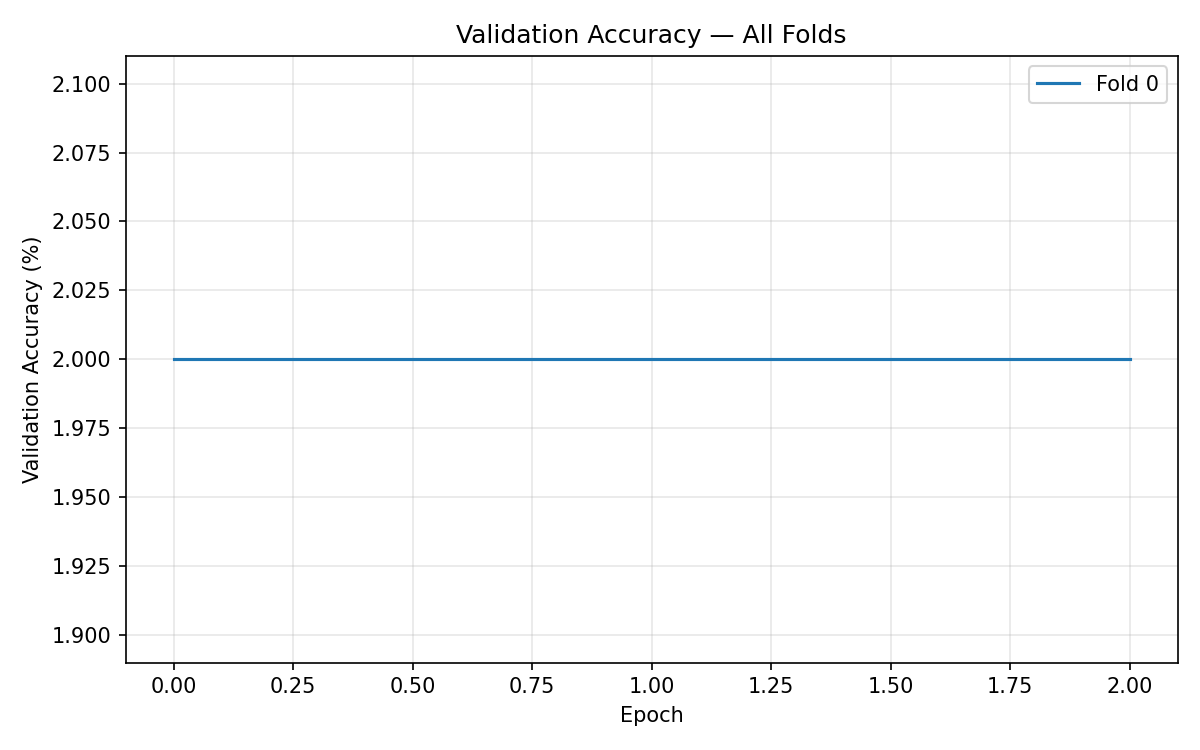

outputs/plots/convergence_fold0.png


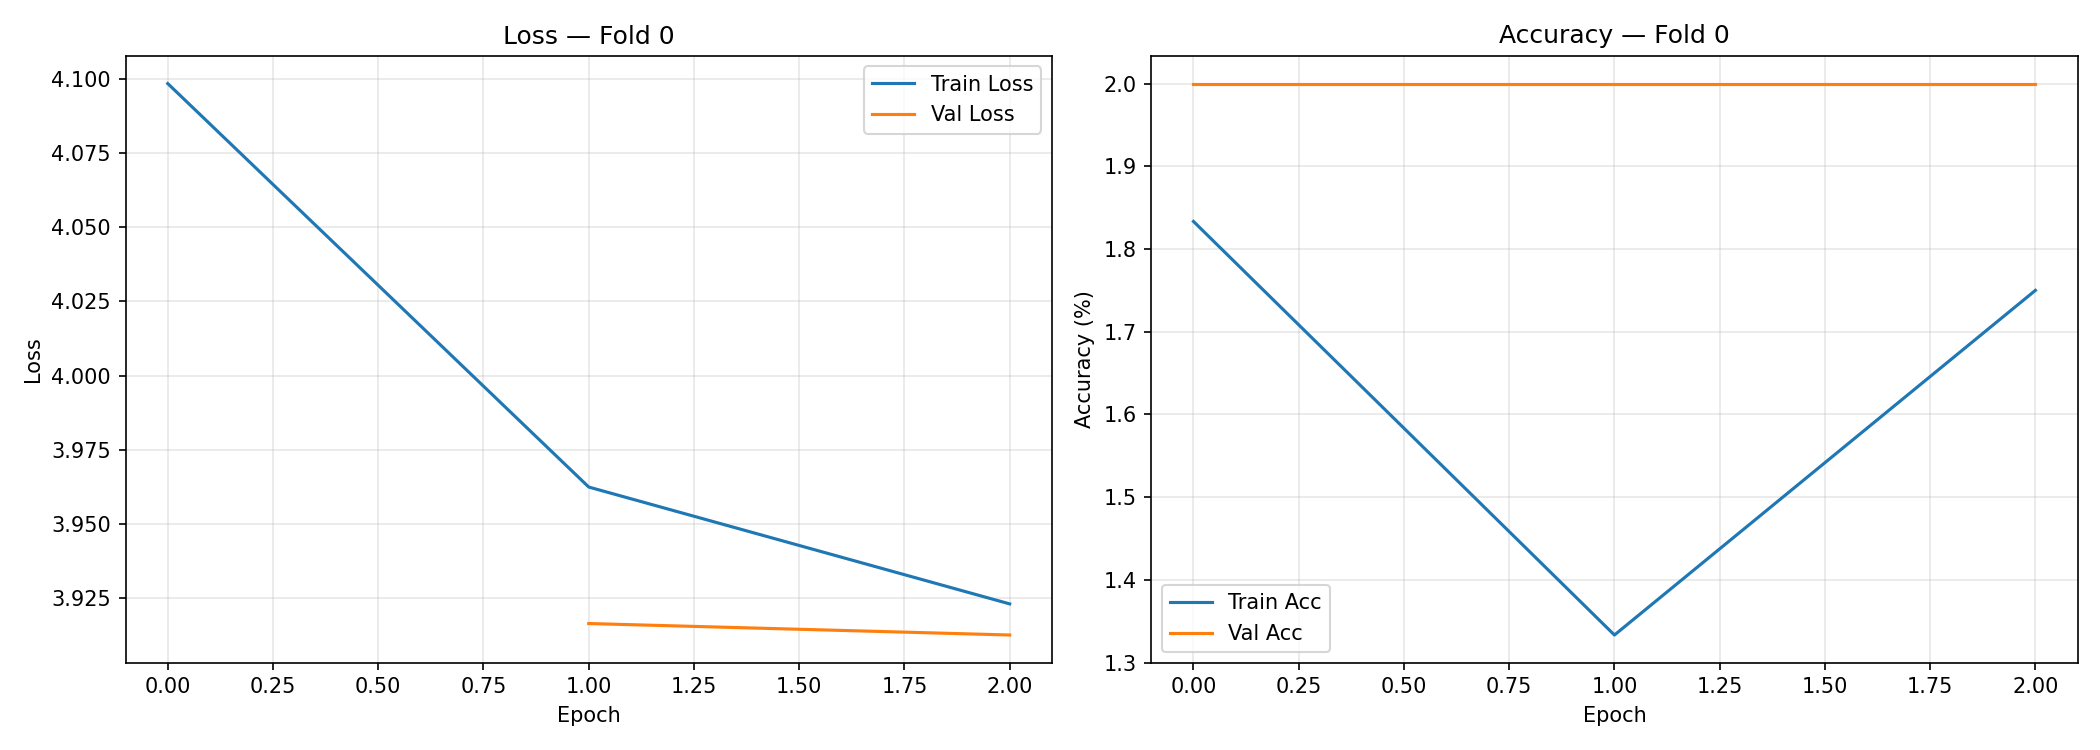

In [31]:
# Display plots inline
from IPython.display import Image, display
import glob

for img_path in sorted(glob.glob('outputs/plots/*.png')):
    print(img_path)
    display(Image(filename=img_path))

## 6. Evaluate Saved Checkpoints

In [ ]:
!python evaluation.py --data_path data --checkpoint_dir outputs --device cuda

## 7. Download Results

Download checkpoints, logs, and plots to your local machine.

In [ ]:
# Zip all outputs for download
!zip -r outputs_bundle.zip outputs/

from google.colab import files
files.download('outputs_bundle.zip')